# Introduction


In this homework, you'll be required to load in a dataset which has about 500 features. By using
Lasso ($L^1$) regression, we'll find the optimal constraint on the $L^1$ norm which gives us the best
$R^2$. Then we'll plot the results.

Recall we minimize the following on ** training data: $(x_i,y_i)$**

$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$


Denoting $\beta_{\lambda}$ as the minimum of the above, we then choose $\lambda$ to maximize $R^2$ on **testing data: $(x_j,y_j)$**

$$ \max_{\lambda} 1 - \frac{\sum_{j} (y_j - \beta_{\lambda} \cdot x_j)^2}{\sum_j (y_j - \bar y)^2}$$


# Lasso Regularization

## Problem 1

a) Load in hw2data.csv from ../data into a pandas dataframe.

In [128]:
import pylab as pplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.random as nprnd
import statsmodels.formula.api as smf
import seaborn
import random
import json
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import Latex
%matplotlib inline

#Part (a): Load Data into Dataframe:
data = pd.read_csv('hw2data.csv')

b) Set y to be the y variable in the dataframe from a and X to be the remaining features.

In [129]:
#Part (b): Set y to be the y data and X to be remaining data
y = data['y']
X = data.drop(['y'],1)

c) As shown in the Booking.com example, using Lasso regression, find the regularization strength
which optimizes the $R^2$. 

**Hint:** Take a range of alpha from `np.logspace(-8,-3,1000)`

In [131]:
#Part (c): Find Regularization Strength that Optimizes R^2 using Lasso Regression
a_range = np.logspace(-8, -3, 1000)

x_tr, x_ts = train_test_split(X, test_size=0.2, random_state=33)
y_tr, y_ts = train_test_split(y, test_size=0.2, random_state=33)

train_errors=[]
test_errors=[]
CF = []
for a in a_range:
    rgrs = Lasso(alpha=a)
    rgrs.fit(x_tr, y_tr)
    train_errors.append(rgrs.score(x_tr,y_tr))
    test_errors.append(rgrs.score(x_ts,y_ts))
    CF.append(rgrs.coef_)
alpha_optim = a_range[np.argmax(test_errors)]    
print('The regularization strength that optimizes the R^2 is ', alpha_optim)

('The regularization strength that optimizes the R^2 is ', 0.000794145171902934)


d) Plot the training perforamnce versus the testing performance, and observe whree the test performance is
maximized. I've written an outline of the code you need.

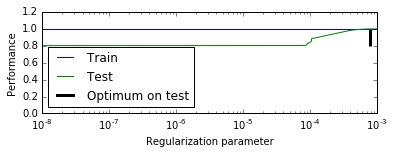

In [132]:
#Part (d): Plot the training perforamnce versus the testing performance
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

plt.show()


The Test Performance is maximized at the higher end of the regularization parameter.

e) Plot the top coefficients based on this optimal paramter. Why do you think so many are zero? 

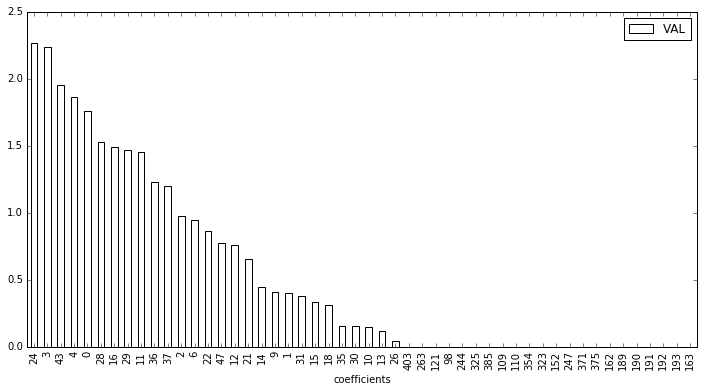

In [133]:
rgrs = Lasso(alpha=alpha_optim)
rgrs.fit(x_tr, y_tr)
CFS = pd.DataFrame({'coefficients':range(len(rgrs.coef_)), 'VAL':rgrs.coef_})
CFS = CFS.sort_values(['VAL'])[::-1]
CFS[0:50].plot(x='coefficients',y='VAL',kind='bar',figsize=(12,6), cmap='Greys')

So many of the coefficients are zero because of the Lasso method used.  Lasso performs a regularization of the data as well as selection of subsets of relevant features which in turn makes some of the coefficients zero.  So the fact that there are so many zero coefficients means that the Lasso is performing as expected, minimizing the sum squared error.

f) Compute the $R^2$ with the optimal coefficient found above on 5 folds using cross_val_score and plot the
results. Does the model work well on all random subsets?

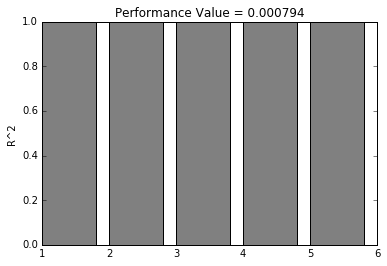

The scores are: 
[0.99963716 0.99999724 0.99999891 0.99999463 0.99999642]


In [134]:
scores = cross_val_score(rgrs, X, y, cv=5)
plt.ylim([0,1])
plt.ylabel('R^2')
plt.title('Performance Value = %f' %alpha_optim)
plt.bar(range(1,6),scores,color='Grey')
plt.show()
print('The scores are: ')
print(scores)

The model works well across all the random subsets, as the $R^2$ value is close to 1 in each scenario.  However, they are all very close to 1 and this could be cause of concern if the model is overfitting the data.

f) Repeat e) but using cross validation. Use error bars on the features which are the standard deviation of the 
coefficiens obtained above. For this problem I"ll walk you through the code. You just need to apply your optimal
$\alpha$ found above. 

In [135]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs



scaler = preprocessing.StandardScaler()
X_scaled = X.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(X)

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_optim)

In [136]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

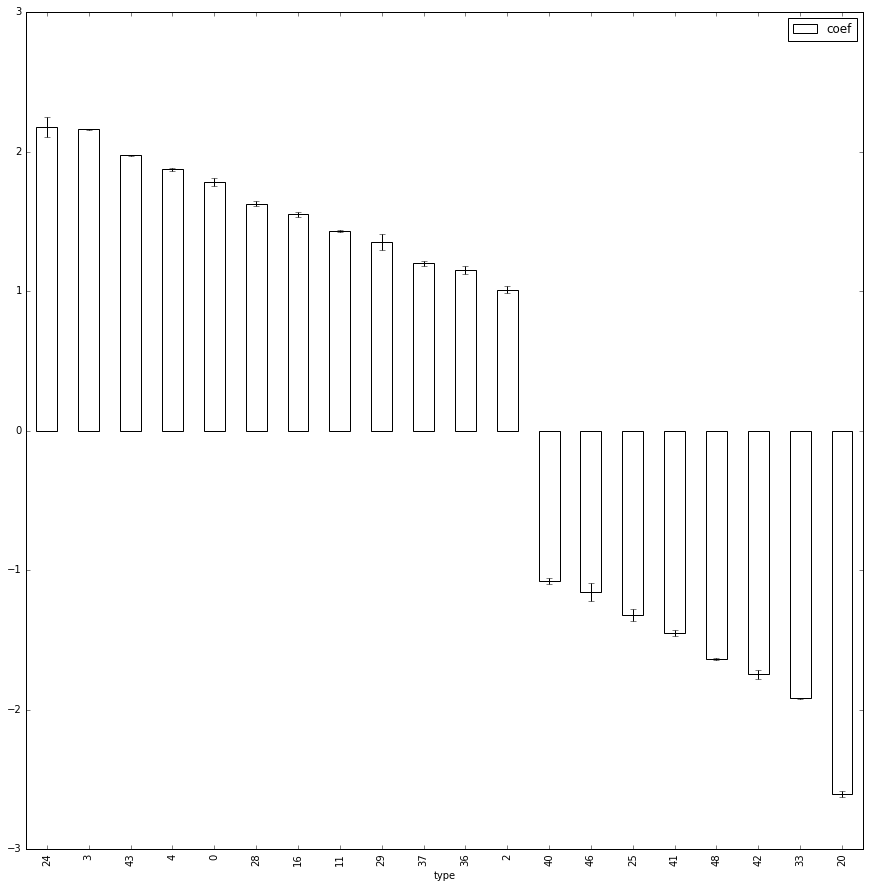

In [137]:
dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
plt.figure(figsize=(15,15))
dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values
dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15),cmap='Greys')